# Imports

In [1]:
import numpy as np
import pandas as pd
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import squarify

import sys
import json
from copy import deepcopy

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [2]:
from itertools import chain, compress
from cge_modeling.base.utilities import variable_dict_to_flat_array
from cge_modeling.production_functions import CES, dixit_stiglitz, leontief
from cge_modeling.gams.from_excel import make_code_dicts

code_dicts = make_code_dicts("data/GTAP_raw_data.xlsx")

In [3]:
import networkx as nx
import graphviz as gr

# Utility Functions

In [4]:
def draw_graph(edge_list, node_props=None, edge_props=None, graph_direction="UD"):
    """Utility to draw a causal (directed) graph"""
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g


from cge_modeling.pytensorf.compile import object_to_pytensor, make_printer_cache, normalize_eq
import pytensor


def make_or_update_cache(pt_vars, pt_params, cache=None, allow_overwrite=False):
    new_cache = make_printer_cache(pt_vars, pt_params)
    new_cache = {k[0]: v for k, v in new_cache.items()}
    if cache is not None:
        for k, v in new_cache.items():
            if k in cache.keys() and not allow_overwrite:
                raise KeyError(
                    f"{k} already exists in cache, check code for duplicate declarations."
                )
            cache[k] = v
    else:
        cache = new_cache
    return cache


def convert_to_pt(variables, parameters, coords, cache=None, allow_overwrite=False):
    pt_vars = [object_to_pytensor(var, coords) for var in variables]
    pt_params = [object_to_pytensor(param, coords) for param in parameters]
    cache = make_or_update_cache(pt_vars, pt_params, cache, allow_overwrite=allow_overwrite)

    return pt_vars, pt_params, cache


def convert_equations(equations, coords, cache=None):
    pt_eqs = []
    for eq in equations:
        try:
            x = eval(normalize_eq(eq.equation), cache.copy())
            pt_eqs.append(x)
        except Exception as e:
            print(f"Could not compile equation: {eq.name}")
            print(e)
            raise e

    return pt_eqs


def test_equations(
    variables, parameters, equations, coords, cache=None, verbose=True, allow_overwrite=True
):
    pt_vars, pt_params, cache = convert_to_pt(
        variables, parameters, coords, cache, allow_overwrite=allow_overwrite
    )

    pt_eqs = convert_equations(equations, coords, cache)

    inputs = list(cache.values())

    rng = np.random.default_rng()
    value_dict = {var.name: rng.beta(1, 1, size=var.type.shape) for var in inputs}

    f = pytensor.function(inputs, pt_eqs, on_unused_input="ignore")
    out = f(**value_dict)
    if verbose:
        for x, name in zip([pt_vars, pt_params, pt_eqs], ["variables", "parameters", "equations"]):
            print(f"Found {len(x)} {name}")
        print(f"Output shapes: {[x.shape for x in out]}")


def calibrate_two_good_CES(fac1, fac2, p1, p2, output, epsilon):
    _rho = (epsilon - 1) / epsilon
    alpha = p1 * fac1 ** (1 / epsilon) / ((p1 * fac1 ** (1 / epsilon) + p2 * fac2 ** (1 / epsilon)))
    A = output * (alpha * fac1**_rho + (1 - alpha) * fac2**_rho) ** (-1 / _rho)
    return A, alpha

# Data and Coords

In [5]:
df = pd.read_csv("data/SRB_SAM_reduced.csv", index_col=[0, 1], header=[0, 1])

In [6]:
energy_dict = code_dicts["energy"]
energy_codes_base = list(energy_dict.keys())
energy_names_base = list(energy_dict.values())
energy_names = sorted(
    list(
        set(
            [
                (
                    x.replace("baseload", "")
                    .replace("peakload", "")
                    .replace("Other", "Other power")
                    .strip()
                )
                for x in energy_names_base
            ]
        )
    )
)
energy_codes = [x.split()[0] + "P" for x in energy_names]

sector_dict = code_dicts["activity"]
sector_dict_rev = {v: k for k, v in sector_dict.items()}

sector_names = sorted([x for x in sector_dict.values() if x not in energy_names_base])
sector_codes = [sector_dict_rev[x] for x in sector_names]

n_sectors = len(sector_codes)
n_energy = len(energy_codes)

coords = {"i": sector_codes, "j": sector_codes, "k": energy_codes}
BACKEND = "pytensor"

In [7]:
sectors = ["Agriculture", "Industry", "Services"]
eprod = ["Coal", "Nuclear"]
n_sectors = len(sectors)
n_eprod = len(eprod)
coords = {"i": sectors, "j": sectors, "k": eprod}

# Model Definition

## Producers of Final Consumption Goods

### Structure

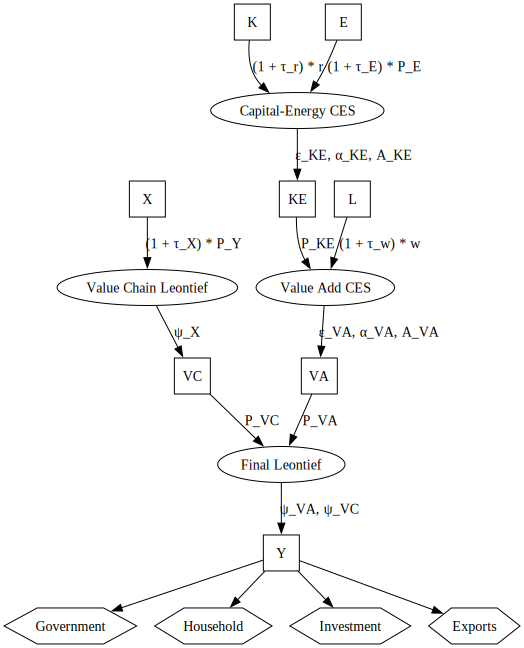

In [8]:
node_props = dict.fromkeys(["VA", "VC", "X", "K", "E", "KE", "L", "Y"], {"shape": "square"})
node_props.update(
    dict.fromkeys(["Government", "Household", "Investment", "Exports"], {"shape": "hexagon"})
)

draw_graph(
    edge_list=[
        ("X", "Value Chain Leontief"),
        ("Value Chain Leontief", "VC"),
        ("K", "Capital-Energy CES"),
        ("E", "Capital-Energy CES"),
        ("Capital-Energy CES", "KE"),
        ("KE", "Value Add CES"),
        ("L", "Value Add CES"),
        ("Value Add CES", "VA"),
        ("VA", "Final Leontief"),
        ("VC", "Final Leontief"),
        ("Final Leontief", "Y"),
        ("Y", "Government"),
        ("Y", "Household"),
        ("Y", "Investment"),
        ("Y", "Exports"),
    ],
    node_props=node_props,
    edge_props={
        ("K", "Capital-Energy CES"): {"label": "(1 + τ_r) * r"},
        ("E", "Capital-Energy CES"): {"label": "(1 + τ_E) * P_E"},
        ("Capital-Energy CES", "KE"): {"label": "ε_KE, α_KE, A_KE"},
        ("KE", "Value Add CES"): {"label": "P_KE"},
        ("L", "Value Add CES"): {"label": "(1 + τ_w) * w"},
        ("Value Add CES", "VA"): {"label": "ε_VA, α_VA, A_VA"},
        ("X", "Value Chain Leontief"): {"label": "(1 + τ_X) * P_Y"},
        ("Value Chain Leontief", "VC"): {"label": "ψ_X"},
        ("VA", "Final Leontief"): {"label": "P_VA"},
        ("VC", "Final Leontief"): {"label": "P_VC"},
        ("Final Leontief", "Y"): {"label": "ψ_VA, ψ_VC"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [9]:
final_firm_variables = [
    # Final Output
    Variable(name="Y", dims=("i"), description="Final output in the <dim:i> sector"),
    # Intermediate Outputs (4)
    Variable(name="VA", dims="i", description="Value-added component of <dim:i> sector production"),
    Variable(name="VC", dims="i", description="Value-chain component of <dim:i> sector production"),
    Variable(
        name="KE",
        dims="i",
        description="Labor Capital demand in the <dim:i> sector",
    ),
    # Root inputs (5)
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    ),
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demand in the <dim:i> sector",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demand in the <dim:i> sector",
    ),
    Variable(
        name="E_d",
        dims="i",
        extend_subscript=True,
        description="Energy demand in the <dim:i> sector",
    ),
    ## Prices (9)
    # Root factors (3)
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(
        name="P_E",
        description="Price of electricity",
    ),
    # Intermediate Outputs (4)
    Variable(
        name="P_KE",
        dims="i",
        extend_subscript=True,
        description="Price of the capital-labor bundle in the <dim:i> sector",
    ),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the value-add component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:i> sector",
    ),
    # Final Prices (2) [domestic + foreign]
    Variable(
        name="P_Y",
        dims=["i"],
        description="Final good price in the <dim:i> sector",
    ),
]

#### Parameters

In [10]:
final_firm_parameters = [
    # CES share parameters (3)
    Parameter(
        "alpha_KE",
        dims="i",
        extend_subscript=True,
        description="Share of capital in production of the <dim:i> producer capital labour bundle",
    ),
    Parameter(
        "alpha_VA",
        dims="i",
        extend_subscript=True,
        description="Share of capital in production of the <dim:i> sector value-add bundle",
    ),
    # CES TFP Parameters (3)
    Parameter("A_VA", dims="i", description="Total factor productivity of the <dim:i> sector"),
    Parameter(
        "A_KE",
        dims="i",
        description="Total factor productivity of Capital-Energy Bundling in the <dim:i> sector",
    ),
    # CES Elasticity Parameters (3)
    Parameter(
        name="epsilon_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    Parameter(
        name="epsilon_KE",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> producer KL bundle",
    ),
    # Leontief share parameters (3)
    Parameter(
        "psi_X",
        dims=("i", "j"),
        extend_subscript=True,
        description="Share of <dim:i> demanded as input to <dim:j> value chain bundle",
    ),
    Parameter(
        "psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of value-add bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of value chain bundle in <dim:i> sector final good production",
    ),
    # Tax rates (5)
    Parameter(
        "tau_w", extend_subscript=True, dims="i", description="Payroll rax tate in <dim:i> sector"
    ),
    Parameter(
        "tau_r",
        extend_subscript=True,
        dims="i",
        description="Capital use tax tax rate in <dim:i> sector",
    ),
    Parameter(
        "tau_E",
        extend_subscript=True,
        dims="i",
        description="Electricity tax rate in <dim:i> sector",
    ),
    Parameter(
        "tau_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="VAT tax paid by <dim:j> on <dim:i> sector inputs",
    ),
    Parameter(
        "tau_Y", extend_subscript=True, dims=("i",), description="Output tax paid my <dim:i>"
    ),
]

#### Equations

In [11]:
capital_energy_bundle = CES(
    factors=["K_d", "E_d"],
    factor_prices=["(1 + tau_r) * r", "(1 + tau_E) * P_E"],
    output="KE",
    output_price="P_KE",
    TFP="A_KE",
    factor_shares="alpha_KE",
    epsilon="epsilon_KE",
    backend=BACKEND,
)

value_add_bundle = CES(
    factors=["KE", "L_d"],
    factor_prices=["P_KE", "(1 + tau_w) * w"],
    output="VA",
    output_price="P_VA",
    TFP="A_VA",
    factor_shares="alpha_VA",
    epsilon="epsilon_VA",
    backend=BACKEND,
)

value_chain_bundle = leontief(
    factors="X",
    factor_prices="(1 + tau_X) * P_Y[:, None]",
    factor_shares="psi_X",
    output="VC",
    output_price="P_VC",
    dims=["i", "j"],
    coords=coords,
    backend=BACKEND,
)

final_goods = leontief(
    factors=["VC", "VA"],
    factor_prices=["P_VC", "P_VA"],
    factor_shares=["psi_VC", "psi_VA"],
    output="Y",
    output_price="(1 - tau_Y) * P_Y",
    dims="i",
    coords=coords,
    backend=BACKEND,
)

In [12]:
final_firm_equations = [
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        value_chain_bundle[0],
    ),
    Equation(
        "Sector <dim:i> demand for sector <dim:j> intermediate input",
        value_chain_bundle[1],
    ),
    # Capital Labour aggregation
    Equation("Producer <dim:i> production of capital-energy bundle", capital_energy_bundle[0]),
    Equation("Producer <dim:i> demand for captial", capital_energy_bundle[1]),
    Equation("Producer <dim:i> demand for energy", capital_energy_bundle[2]),
    # Value add bundle
    Equation("Sector <dim:i> production of value add", value_add_bundle[0]),
    Equation("Sector <dim:i> demand for capital energy bundle", value_add_bundle[1]),
    Equation("Sector <dim:i> demand for labour", value_add_bundle[2]),
    # Sector Final Goods
    Equation("Final good production of sector <dim:i>", final_goods[0]),
    Equation("Sector <dim:i> demand for intermediate goods bundle", final_goods[1]),
    Equation("Sector <dim:i> demand for value added", final_goods[2]),
]

##### Test Equations

In [13]:
*_, cache = convert_to_pt(final_firm_variables, final_firm_parameters, coords)
test_equations(final_firm_variables, final_firm_parameters, final_firm_equations, coords)

Found 15 variables
Found 14 parameters
Found 11 equations
Output shapes: [(3,), (3, 3), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,), (3,)]


## Producers of Energy

### Structure

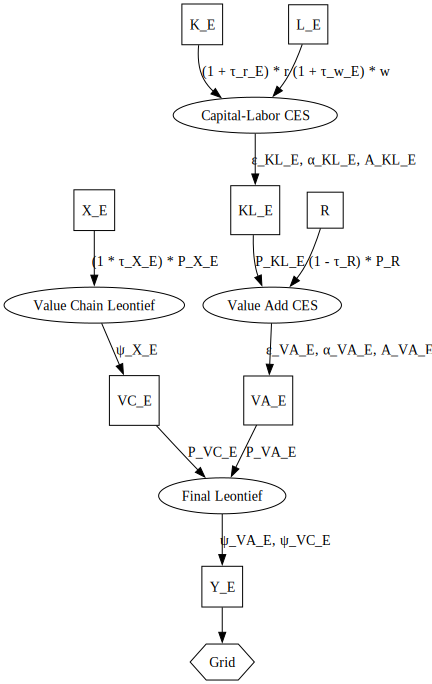

In [14]:
node_props = dict.fromkeys(
    ["VA_E", "VC_E", "X_E", "K_E", "R", "KL_E", "L_E", "Y_E"], {"shape": "square"}
)
node_props.update(dict.fromkeys(["Grid"], {"shape": "hexagon"}))

draw_graph(
    edge_list=[
        ("X_E", "Value Chain Leontief"),
        ("Value Chain Leontief", "VC_E"),
        ("K_E", "Capital-Labor CES"),
        ("L_E", "Capital-Labor CES"),
        ("Capital-Labor CES", "KL_E"),
        ("KL_E", "Value Add CES"),
        ("R", "Value Add CES"),
        ("Value Add CES", "VA_E"),
        ("VA_E", "Final Leontief"),
        ("VC_E", "Final Leontief"),
        ("Final Leontief", "Y_E"),
        ("Y_E", "Grid"),
    ],
    node_props=node_props,
    edge_props={
        ("K_E", "Capital-Labor CES"): {"label": "(1 + τ_r_E) * r"},
        ("L_E", "Capital-Labor CES"): {"label": "(1 + τ_w_E) * w"},
        ("Capital-Labor CES", "KL_E"): {"label": "ε_KL_E, α_KL_E, A_KL_E"},
        ("KL_E", "Value Add CES"): {"label": "P_KL_E"},
        ("R", "Value Add CES"): {"label": "(1 - τ_R) * P_R"},
        ("Value Add CES", "VA_E"): {"label": "ε_VA_E, α_VA_E, A_VA_E"},
        ("X_E", "Value Chain Leontief"): {"label": "(1 * τ_X_E) * P_X_E"},
        ("Value Chain Leontief", "VC_E"): {"label": "ψ_X_E"},
        ("VA_E", "Final Leontief"): {"label": "P_VA_E"},
        ("VC_E", "Final Leontief"): {"label": "P_VC_E"},
        ("Final Leontief", "Y_E"): {"label": "ψ_VA_E, ψ_VC_E"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [15]:
energy_firm_variables = [
    # Top-level output (1)
    Variable(name="Y_E", dims=("k",), description="Final output in the <dim:k> energy sector"),
    # Intermediate outputs (4)
    Variable(name="VC_E", dims="k", description="Value-chain component of <dim:k> energy producer"),
    Variable(
        name="VA_E", dims="k", description="Value-added component of <dim:k> sector production"
    ),
    Variable(
        name="KL_E",
        dims="k",
        extend_subscript=True,
        description="Capital energy bundle Capital demand in the <dim:k> e-sector",
    ),
    # Root inputs (5)
    Variable(
        name="X_E",
        dims=("i", "k"),
        description="Demand for <dim:i> sector goods by the <dim:k> sector",
    ),
    Variable(
        name="L_E_d",
        dims="k",
        extend_subscript=True,
        description="Labor demand in the <dim:k> e-sector",
    ),
    Variable(
        name="K_E_d",
        dims="k",
        extend_subscript=True,
        description="Capital demand in the <dim:k> e-sector",
    ),
    Variable(
        name="R_d",
        dims="k",
        extend_subscript=True,
        description="Raw resource demand of <dim:k> sector",
    ),
    ## Prices
    # Final output
    Variable(
        name="P_Y_E",
        dims=("k",),
        extend_subscript=True,
        description="Price of energy output by <dim:k> sector",
    ),
    # Intermediate outputs (4)
    Variable(
        name="P_KL_E",
        dims="k",
        extend_subscript=True,
        description="Price of capital-labor bundle formed by <dim:k> sector",
    ),
    Variable(
        name="P_VA_E",
        dims="k",
        extend_subscript=True,
        description="Price of value-add bundle in <dim:k> sector",
    ),
    Variable(
        name="P_VC_E",
        dims="k",
        extend_subscript=True,
        description="Price of value chain bundle in <dim:k> sector",
    ),
    # Root inputs (5)
    # P_Y, r, w are defined above
    Variable(
        name="P_R",
        dims="k",
        extend_subscript=True,
        description="Price of <dim:k> raw resource input",
    ),
]

#### Parameters

In [16]:
energy_firm_parameters = [
    # CES share parameters (3)
    Parameter(
        "alpha_KL_E",
        dims="k",
        description="Share of capital in production of the <dim:k> producer capital labour bundle",
    ),
    Parameter(
        "alpha_VA_E",
        dims="k",
        description="Share of capital in production of the <dim:k> producer capital labour bundle",
    ),
    # CES TFP parameters (3)
    Parameter(
        "A_KL_E", dims="k", description="Captial Labour factor productivity of <dim:k> producer"
    ),
    Parameter("A_VA_E", dims="k", description="Total factor productivity of the <dim:k> sector"),
    # CES elasticity parameters (3)
    Parameter(
        name="epsilon_KL_E",
        extend_subscript=True,
        dims="k",
        description="Elasticity of subsitution between capial and labor in <dim:k>",
    ),
    Parameter(
        name="epsilon_VA_E",
        extend_subscript=True,
        dims="k",
        description="Elasticity of subsitution between VA and VC in <dim:k>",
    ),
    # Leontief share parameters (3)
    Parameter(
        "psi_X_E",
        extend_subscript=True,
        dims=("i", "k"),
        description="Share of <dim:i> sector final goods in the <dim:k> value chain bundle",
    ),
    Parameter(
        "psi_VC_E",
        extend_subscript=True,
        dims="k",
        description="Share of value chain bundle in <dim:k> sector final good production",
    ),
    Parameter(
        "psi_VA_E",
        extend_subscript=True,
        dims="k",
        description="Share of value add bundle in <dim:k> sector final good production",
    ),
    # Tax rates (5)
    Parameter(
        "tau_w_E", extend_subscript=True, dims="k", description="Payroll rax tate in <dim:k> sector"
    ),
    Parameter(
        "tau_r_E",
        extend_subscript=True,
        dims="k",
        description="Capital use tax rate in <dim:k> sector",
    ),
    Parameter(
        "tau_R",
        extend_subscript=True,
        dims="k",
        description="Raw material tax rate in <dim:k> sector",
    ),
    Parameter(
        "tau_X_E",
        extend_subscript=True,
        dims=("i", "k"),
        description="VAT tax paid by <dim:k> sector on <dim:i> inputs",
    ),
    Parameter(
        "tau_Y_E",
        extend_subscript=True,
        dims=("k",),
        description="Output tax paid by <dim:k> sector",
    ),
]

#### Equations

In [17]:
capital_labor_bundle = CES(
    factors=["K_E_d", "L_E_d"],
    factor_prices=["(1 + tau_r_E) * r", "(1 + tau_w_E) * w"],
    output="KL_E",
    output_price="P_KL_E",
    TFP="A_KL_E",
    factor_shares="alpha_KL_E",
    epsilon="epsilon_KL_E",
    backend=BACKEND,
)

value_add_bundle = CES(
    factors=["KL_E", "R_d"],
    factor_prices=["P_KL_E", "(1 + tau_R) * P_R"],
    output="VA_E",
    output_price="P_VA_E",
    TFP="A_VA_E",
    factor_shares="alpha_VA_E",
    epsilon="epsilon_VA_E",
    backend=BACKEND,
)


value_chain_bundle = leontief(
    factors="X_E",
    factor_prices="(1 + tau_X_E) * P_Y[:, None]",
    factor_shares="psi_X_E",
    output="VC_E",
    output_price="P_VC_E",
    dims=["i", "k"],
    coords=coords,
    backend=BACKEND,
)

final_goods = leontief(
    factors=["VC_E", "VA_E"],
    factor_prices=["P_VC_E", "P_VA_E"],
    factor_shares=["psi_VC_E", "psi_VA_E"],
    output="Y_E",
    output_price="((1 - tau_Y_E) * P_Y_E)",
    dims="k",
    coords=coords,
    backend=BACKEND,
)

In [18]:
energy_firm_equations = [
    # Value chain bundle
    Equation(
        "Sector <dim:k> production of intermediate goods bundle",
        value_chain_bundle[0],
    ),
    Equation(
        "Sector <dim:k> demand for sector <dim:i> intermediate input",
        value_chain_bundle[1],
    ),
    # Capital Labour aggregation
    Equation("Producer <dim:k> production of capital-labor bundle", capital_labor_bundle[0]),
    Equation("Producer <dim:k> demand for captial", capital_labor_bundle[1]),
    Equation("Producer <dim:k> demand for labor", capital_labor_bundle[2]),
    # Value add bundle
    Equation("Sector <dim:k> production of value add", value_add_bundle[0]),
    Equation("Sector <dim:k> demand for capital energy bundle", value_add_bundle[1]),
    Equation("Sector <dim:k> demand for resource input", value_add_bundle[2]),
    # Sector Final Goods
    Equation("Final good production of sector <dim:k>", final_goods[0]),
    Equation("Sector <dim:k> demand for intermediate goods bundle", final_goods[1]),
    Equation("Sector <dim:k> demand for value added", final_goods[2]),
]

In [19]:
*_, cache = convert_to_pt(
    energy_firm_variables, energy_firm_parameters, coords, cache, allow_overwrite=False
)
test_equations(
    energy_firm_variables, energy_firm_parameters, energy_firm_equations, coords, cache=cache
)

Found 13 variables
Found 14 parameters
Found 11 equations
Output shapes: [(2,), (3, 2), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,)]


## Electricity Producer (Grid)

### Structure

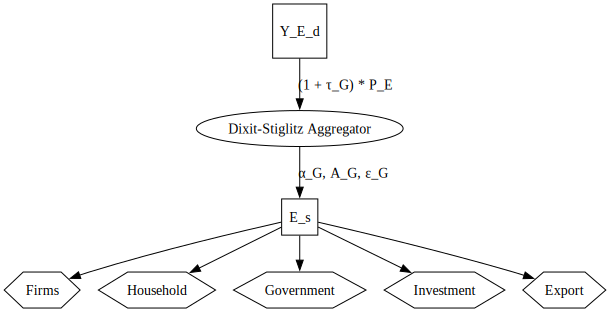

In [20]:
node_props = dict.fromkeys(["Y_E_d", "E_s"], {"shape": "square"})
node_props.update(
    dict.fromkeys(
        ["Firms", "Household", "Government", "Investment", "Export"], {"shape": "hexagon"}
    )
)

draw_graph(
    edge_list=[
        ("Y_E_d", "Dixit-Stiglitz Aggregator"),
        ("Dixit-Stiglitz Aggregator", "E_s"),
        ("E_s", "Firms"),
        ("E_s", "Household"),
        ("E_s", "Government"),
        ("E_s", "Investment"),
        ("E_s", "Export"),
    ],
    node_props=node_props,
    edge_props={
        ("Import-Export CES", "Y_E_d"): {"label": "α_E, A_E, ε_E"},
        ("Y_E_d", "Dixit-Stiglitz Aggregator"): {"label": "(1 + τ_G) * P_E"},
        ("Dixit-Stiglitz Aggregator", "E_s"): {"label": "α_G, A_G, ε_G"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [21]:
grid_variables = [
    # Final Output
    Variable(name="E_s", description="Total electricity supplied by the grid"),
    # Inputs
    Variable(
        name="Y_E_d",
        dims=("k",),
        extend_subscript=True,
        description="Grid demand for energy produced by <dim:k> sector",
    ),
]

#### Parameters

In [22]:
grid_parameters = [
    # DX Parameters (3)
    Parameter(
        name="alpha_G",
        dims="k",
        description="Share of <dim:k> energy in the production of electricity",
    ),
    Parameter(name="A_G", description="Total factor productivity of grid electricity production"),
    Parameter(
        name="epsilon_G",
        description="Elasticity of subsitution between energy varieties in grid production",
    ),
    # Taxes
    Parameter(
        name="tau_G",
        dims=[
            "k",
        ],
        extend_subscript=True,
        description="Sales tax on <dim:k> energy purchases by the grid",
    ),
]

#### Equations

In [23]:
electricity_production = dixit_stiglitz(
    factors="Y_E_d",
    factor_prices="(1 + tau_G) * P_Y_E",
    output="E_s",
    output_price="P_E",
    TFP="A_G",
    factor_shares="alpha_G",
    epsilon="epsilon_G",
    dims="k",
    coords=coords,
    backend=BACKEND,
)

In [24]:
grid_equations = [
    # Production of electricity
    Equation("Grid production of electricity", electricity_production[0]),
    Equation("Grid demand for <dim:k> energy", electricity_production[1]),
]

In [25]:
*_, cache = convert_to_pt(grid_variables, grid_parameters, coords, cache)
test_equations(grid_variables, grid_parameters, grid_equations, coords, cache)

Found 2 variables
Found 4 parameters
Found 2 equations
Output shapes: [(), (2,)]


## Household

### Structure

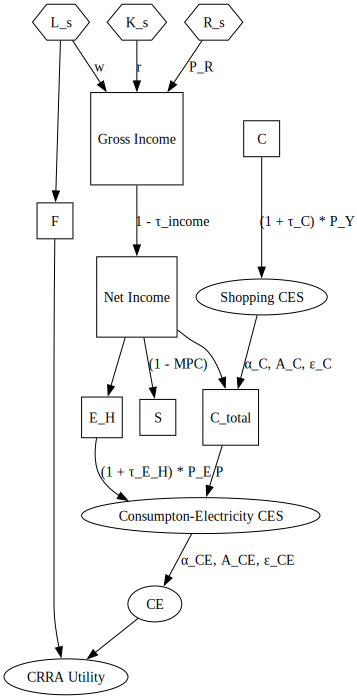

In [26]:
node_props = dict.fromkeys(
    ["E_H", "L_s", "F", "S", "C", "C_total", "Gross Income", "Net Income"], {"shape": "square"}
)
node_props.update(dict.fromkeys(["K_s", "R_s", "L_s"], {"shape": "hexagon"}))

draw_graph(
    edge_list=[
        ("C", "Shopping CES"),
        ("Shopping CES", "C_total"),
        ("C_total", "Consumpton-Electricity CES"),
        ("E_H", "Consumpton-Electricity CES"),
        ("Consumpton-Electricity CES", "CE"),
        ("L_s", "F"),
        ("F", "CRRA Utility"),
        ("CE", "CRRA Utility"),
        ("L_s", "Gross Income"),
        ("K_s", "Gross Income"),
        ("R_s", "Gross Income"),
        ("Gross Income", "Net Income"),
        ("Net Income", "C_total"),
        ("Net Income", "S"),
        ("Net Income", "E_H"),
    ],
    node_props=node_props,
    edge_props={
        ("C", "Shopping CES"): {"label": "(1 + τ_C) * P_Y"},
        ("Shopping CES", "C_total"): {"label": "α_C, A_C, ε_C"},
        ("L_s", "Gross Income"): {"label": "w"},
        ("K_s", "Gross Income"): {"label": "r"},
        ("R_s", "Gross Income"): {"label": "P_R"},
        ("Net Income", "S"): {"label": "(1 - MPC)"},
        ("Gross Income", "Net Income"): {"label": "1 - τ_income"},
        ("E_H", "Consumpton-Electricity CES"): {"label": "(1 + τ_E_H) * P_E"},
        ("C_total", "Consumpton-Electricity CES"): {"label": "P"},
        ("Consumpton-Electricity CES", "CE"): {"label": "α_CE, A_CE, ε_CE"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [27]:
household_variables = [
    # Inputs to shopping
    Variable(name="C", dims=("i",), description="Household demand for <dim:i> goods"),
    # Inputs to final consumption basket
    Variable(name="E_H_d", description="Household demand for electricity"),
    Variable(
        name="C_total", latex_name=r"\bar{C}", description="Household final consumption bundle"
    ),
    # Spending variables
    Variable(name="F", description="Household leisure time"),
    Variable(name="S", description="Household savings"),
    # Variable(name='CE', description='Consumption-Electricity bundle'),
    # Income definitions
    Variable(name="L_s", description="Household supply of labor"),
    Variable(
        name="income",  # Gross Income above
        latex_name="Omega",
        description="Household income, before taxes",
    ),
    Variable(
        name="net_income", latex_name="\hat{\Omega}", description="Household income, after taxes"
    ),
    # Prices
    Variable(name="P", description="Consumer Price Index"),
    # Utility
    Variable(name="U", description="Household utility"),
]

#### Parameters

In [28]:
household_parameters = [
    # Factor endowments
    Parameter(name="T", description="Time endowment"),
    Parameter(name="K_s", description="Capital stock"),
    Parameter(name="R_s", dims="k", description="Endowment of <dim:k> resource factor"),
    # Shopping CES parameters
    Parameter(
        name="alpha_C",
        dims="i",
        description="Household elasticity of consumption utility for <dim:i> sector goods",
    ),
    Parameter(name="A_C", description="Household total factor productivity of shopping"),
    Parameter(
        name="epsilon_C",
        description="Elasticity of substitution between varieties in final consumption basket",
    ),
    # Utility Parameters
    Parameter(
        name="sigma_C",
        description="Arrow-Pratt risk averson",
    ),
    Parameter(name="sigma_L", description="Inverse Frisch elasticity between work and leisure"),
    Parameter(name="Theta", description="Household labor dispreference parameter"),
    # Miscellaneous
    Parameter(name="mpc", latex_name="phi", description="Household marginal propensity to consume"),
    # Taxes
    Parameter(
        name="tau_C", dims=["i"], description="Sales tax paid by households for <dim:i> goods"
    ),
    Parameter(name="tau_E_H", description="Sales tax paid by households for electricity"),
    Parameter(name="tau_income", description="Income tax paid by households"),
]

#### Equations

In [29]:
# shopping_function = dixit_stiglitz(
#     factors="C",
#     factor_prices="((1 + tau_C) * P_Y)",
#     output="C_total",
#     output_price="P",
#     TFP="A_C",
#     factor_shares="alpha_C",
#     epsilon="epsilon_C",
#     dims="i",
#     coords=coords,
#     backend=BACKEND,
# )

# consumption_electricity_bundle = CES(
#     factors = ['C_total', 'E_H_d'],
#     factor_prices = ['P', '(1 + tau_E_H) * P_E'],
#     output = 'CE',
#     output_price = 'P_CE',
#     TFP='A_CE',
#     factor_shares='alpha_CE',
#     epsilon = 'epsilon_CE',
#     backend=BACKEND
# )

shopping_eq_total = """C_total = A_C * 
                            ((alpha_C * C ** ((epsilon_C - 1) / epsilon_C)).sum() + 
                             (1 - alpha_C.sum()) * E_H_d ** ((epsilon_C - 1) / epsilon_C)) ** 
                            (epsilon_C / (epsilon_C - 1))"""

shopping_factor_demand = (
    """C = C_total / A_C * (A_C * alpha_C * P / ((1 + tau_C) * P_Y)) ** epsilon_C"""
)
shopping_electricity_demand = """E_H_d = C_total / A_C * (A_C * (1 - alpha_C.sum()) * P / ((1 + tau_E_H) * P_E)) ** epsilon_C"""

In [30]:
household_equations = [
    # Production of consumption basket (shopping)
    Equation("Final consumption bundle", shopping_eq_total),
    Equation("Household demand for <dim:i> goods", shopping_factor_demand),
    Equation("Household demand for electricity", shopping_electricity_demand),
    # # Basket-Electricity bundle
    # Equation("Goods-Electricity bundle", consumption_electricity_bundle[0]),
    # Equation("Household demand for goods basket", consumption_electricity_bundle[1]),
    # Equation("Household demand for electricity", consumption_electricity_bundle[2]),
    # Income
    Equation(
        "Household pre-tax income",
        "income = w * L_s + r * K_s + (R_d * P_R).sum()",
    ),
    Equation("Household after-tax income", "net_income = (1 - tau_income) * income"),
    Equation("Household budget constraint", "C_total * P = mpc * net_income"),
    Equation(
        "Household utility",
        "U = C_total ** (1 - sigma_C) / (1 - sigma_C) + F ** (1 - sigma_L) / (1 - sigma_L)",
    ),
    Equation("Household supply of labor", "F ** -sigma_L / C_total ** -sigma_C = w / P / Theta"),
    Equation("Household savings", "S = (1 - mpc) * net_income"),
]

In [31]:
*_, cache = convert_to_pt(
    household_variables, household_parameters, coords, cache, allow_overwrite=False
)
test_equations(household_variables, household_parameters, household_equations, coords, cache)

Found 10 variables
Found 13 parameters
Found 9 equations
Output shapes: [(), (3,), (), (), (), (), (), (), ()]


## Investment

### Structure

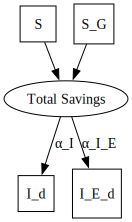

In [32]:
node_props = dict.fromkeys(["I_d", "I_E_d", "S", "S_G"], {"shape": "square"})

draw_graph(
    edge_list=[
        ("S", "Total Savings"),
        ("S_G", "Total Savings"),
        ("Total Savings", "I_d"),
        ("Total Savings", "I_E_d"),
    ],
    node_props=node_props,
    edge_props={
        ("Total Savings", "I_d"): {"label": "α_I"},
        ("Total Savings", "I_E_d"): {"label": "α_I_E"},
    },
    graph_direction="UD",
)

### Implementation

#### Variables

In [33]:
investment_variables = [
    Variable(name="I_s", description="Total supply of capital"),
    Variable(
        name="I_d",
        dims=[
            "i",
        ],
        description="Demand for investment capital by the <dim:i> sector",
    ),
    Variable(
        name="I_E_d",
        dims=[
            "k",
        ],
        description="Demand for investment capital by the <dim:k> sector",
    ),
]

#### Parameters

In [34]:
investment_parameters = [
    Parameter("S_G", description="Supply of government investment capital"),
    Parameter("alpha_I", dims="i", description="<dim:i> share of total investment"),
    Parameter("alpha_I_E", dims="k", description="<dim:k> share of total investment"),
    Parameter("tau_I", dims="i", description="Tax on capital in sector <dim:i>"),
    Parameter("tau_I_E", dims="k", description="Tax on capital in section <dim:k>"),
]

#### Equations

In [35]:
investment_equations = [
    Equation("<dim:i> sector demand for capital", "(1 + tau_I) * P_Y * I_d = alpha_I * I_s"),
    Equation(
        "<dim:k> sector demand for capital", "(1 + tau_I_E) * P_Y_E * I_E_d = alpha_I_E * I_s"
    ),
]

In [36]:
*_, cache = convert_to_pt(
    investment_variables, investment_parameters, coords, cache, allow_overwrite=False
)
test_equations(investment_variables, investment_parameters, investment_equations, coords, cache)

Found 3 variables
Found 5 parameters
Found 2 equations
Output shapes: [(3,), (2,)]


## Government

### Structure

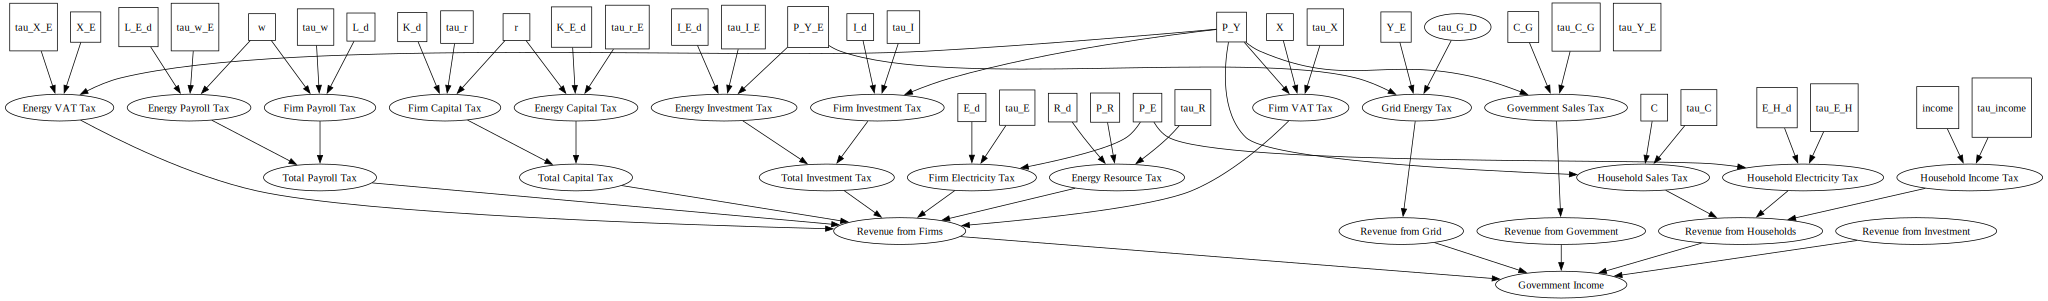

In [37]:
all_taxes = [
    "tau_w",
    "tau_w_E",
    "tau_r",
    "tau_r_E",
    "tau_E",
    "tau_E_H",
    "tau_X",
    "tau_X_E",
    "tau_C",
    "tau_C_G",
    "tau_I",
    "tau_I_E",
    "tau_Y_E",
    "tau_R",
    "tau_income",
]
taxed_prices = ["P_Y", "w", "r", "P_Y_E", "P_E", "P_R"]

taxed_quantities = [
    "L_d",
    "L_E_d",
    "K_d",
    "K_E_d",
    "E_d",
    "E_H_d",
    "X",
    "X_E",
    "R_d",
    "I_d",
    "I_E_d",
    "income",
    "Y_E",
    "C_G",
    "C",
]

node_props = dict.fromkeys(all_taxes + taxed_prices + taxed_quantities, {"shape": "square"})

draw_graph(
    edge_list=[
        ("L_d", "Firm Payroll Tax"),
        ("w", "Firm Payroll Tax"),
        ("tau_w", "Firm Payroll Tax"),
        ("L_E_d", "Energy Payroll Tax"),
        ("tau_w_E", "Energy Payroll Tax"),
        ("w", "Energy Payroll Tax"),
        ("K_d", "Firm Capital Tax"),
        ("r", "Firm Capital Tax"),
        ("tau_r", "Firm Capital Tax"),
        ("K_E_d", "Energy Capital Tax"),
        ("tau_r_E", "Energy Capital Tax"),
        ("r", "Energy Capital Tax"),
        ("X", "Firm VAT Tax"),
        ("P_Y", "Firm VAT Tax"),
        ("tau_X", "Firm VAT Tax"),
        ("E_d", "Firm Electricity Tax"),
        ("P_E", "Firm Electricity Tax"),
        ("tau_E", "Firm Electricity Tax"),
        ("R_d", "Energy Resource Tax"),
        ("P_R", "Energy Resource Tax"),
        ("tau_R", "Energy Resource Tax"),
        ("X_E", "Energy VAT Tax"),
        ("tau_X_E", "Energy VAT Tax"),
        ("P_Y", "Energy VAT Tax"),
        ("Y_E", "Grid Energy Tax"),
        ("P_Y_E", "Grid Energy Tax"),
        ("tau_G_D", "Grid Energy Tax"),
        ("I_d", "Firm Investment Tax"),
        ("P_Y", "Firm Investment Tax"),
        ("tau_I", "Firm Investment Tax"),
        ("I_E_d", "Energy Investment Tax"),
        ("P_Y_E", "Energy Investment Tax"),
        ("tau_I_E", "Energy Investment Tax"),
        ("C_G", "Government Sales Tax"),
        ("P_Y", "Government Sales Tax"),
        ("tau_C_G", "Government Sales Tax"),
        ("C", "Household Sales Tax"),
        ("P_Y", "Household Sales Tax"),
        ("tau_C", "Household Sales Tax"),
        ("E_H_d", "Household Electricity Tax"),
        ("P_E", "Household Electricity Tax"),
        ("tau_E_H", "Household Electricity Tax"),
        ("income", "Household Income Tax"),
        ("tau_income", "Household Income Tax"),
        ("Firm Payroll Tax", "Total Payroll Tax"),
        ("Energy Payroll Tax", "Total Payroll Tax"),
        ("Total Payroll Tax", "Revenue from Firms"),
        ("Firm Capital Tax", "Total Capital Tax"),
        ("Energy Capital Tax", "Total Capital Tax"),
        ("Total Capital Tax", "Revenue from Firms"),
        ("Firm Investment Tax", "Total Investment Tax"),
        ("Energy Investment Tax", "Total Investment Tax"),
        ("Total Investment Tax", "Revenue from Firms"),
        ("Firm VAT Tax", "Revenue from Firms"),
        ("Energy VAT Tax", "Revenue from Firms"),
        ("Firm Electricity Tax", "Revenue from Firms"),
        ("Energy Resource Tax", "Revenue from Firms"),
        ("Grid Energy Tax", "Revenue from Grid"),
        ("Government Sales Tax", "Revenue from Government"),
        ("Household Electricity Tax", "Revenue from Households"),
        ("Household Sales Tax", "Revenue from Households"),
        ("Household Income Tax", "Revenue from Households"),
        ("Revenue from Grid", "Government Income"),
        ("Revenue from Firms", "Government Income"),
        ("Revenue from Investment", "Government Income"),
        ("Revenue from Government", "Government Income"),
        ("Revenue from Households", "Government Income"),
    ],
    node_props=node_props,
    edge_props={},
    graph_direction="UD",
)

### Implementation

#### Variables

In [38]:
government_variables = [
    Variable(name="G", description="Government budget"),
    Variable(
        name="C_G",
        dims=("i",),
        extend_subscript=True,
        description="Government consumption of <dim:i> goods",
    ),
]

#### Parameters

In [39]:
government_parameteres = [
    Parameter(
        "alpha_Gov",
        dims="i",
        description="Share of <dim:i> sector final goods in governmnet consumption",
    ),
    Parameter(
        name="tau_C_G",
        dims=("i",),
        description="Tax rate paid by government for sector <dim:i> goods",
    ),
]

#### Equations

In [40]:
government_equations = [
    Equation(
        "Government budget constraint",
        "G + S_G = "
        # Firm taxes
        "(tau_X * P_Y[:, None] * X).sum() +"  # Firm VAT
        "(tau_w * L_d * w).sum() +"  # Firm payroll tax
        "(tau_r * K_d * r).sum() +"  # Firm capital use tax
        "(tau_E * E_d * P_E).sum() +"  # Firm electricity
        "(tau_Y * P_Y[:, None] * Y).sum() +"  # Firm output tax
        # # Energy producer taxes
        "(tau_X_E * P_Y[:, None] * X_E).sum() +"  # Energy VAT
        "(tau_w_E * L_E_d * w).sum() +"  # Energy payroll tax
        "(tau_r_E * K_E_d * r).sum() +"  # Energy capital use tax
        "(tau_R * R_d * P_R).sum() +"  # Energy resource use tax
        "(tau_Y_E * P_Y_E[:, None] * Y_E).sum() +"  # Firm output tax
        # # Grid
        "(tau_G * Y_E * P_Y_E).sum() +"  # Energy inputs to electricity production
        # # Investment
        "(tau_I * I_d * P_Y).sum() +"  # Tax on capital investment
        "(tau_I_E * I_E_d * P_Y_E).sum() +"  # Tax on capital investment
        # # Household
        "(tau_C * P_Y * C).sum() +"  # Consumption
        "(tau_E_H * E_H_d * P_E).sum() +"  # Household electricity
        "(tau_income * income) +"  # Income tax (direct tax)
        # Government
        "(tau_C_G * P_Y * C_G).sum()",  # Government consumption
    ),
    Equation("Government consumption of <dim:i> sector goods", "C_G = alpha_Gov * G"),
]

In [41]:
*_, cache = convert_to_pt(
    government_variables, government_parameteres, coords, cache, allow_overwrite=False
)
test_equations(government_variables, government_parameteres, government_equations, coords, cache)

Found 2 variables
Found 2 parameters
Found 2 equations
Output shapes: [(), (3,)]


## Market Clearing

### Structure

### Implementation

#### Variables

In [42]:
clearing_variables = [Variable("resid", description="Walrasian residual")]

#### Parameters

In [43]:
# Exogenous values
clearing_parameters = [
    Parameter("P_num", latex_name=r"\\bar{P}_{num}", description="Numeraire price"),
]

#### Equations

In [44]:
clearing_equations = [
    # Factor markets
    Equation("Labour market clearing", "L_s = L_d.sum() + L_E_d.sum()"),
    Equation("Capital market clearing", "K_s = K_d.sum() + K_E_d.sum()"),
    Equation("Energy resource market clearing <dim:k>", "R_s = R_d"),
    Equation("Electricity market clearing", "E_s = E_d.sum() + E_H_d"),
    # Investment market
    Equation("Investment market clearing", "I_s = S + S_G + resid"),
    # Goods markets
    Equation("<dim:k> energy market clearing", "Y_E = Y_E_d"),
    Equation(
        "Sector <dim:i> goods market clearing",
        "Y = C + C_G + I_d + X.sum(axis=1) + X_E.sum(axis=1)",
    ),
    # Misc.
    Equation("Total time constraint", "T = L_s + F"),
    Equation("Numeraire", "w = P_num"),
]

In [45]:
*_, cache = convert_to_pt(
    clearing_variables, clearing_parameters, coords, cache, allow_overwrite=False
)
test_equations(clearing_variables, clearing_parameters, clearing_equations, coords, cache)

Found 1 variables
Found 1 parameters
Found 9 equations
Output shapes: [(), (), (2,), (), (), (2,), (3,), (), ()]


In [46]:
all_parameters = (
    final_firm_parameters
    + energy_firm_parameters
    + grid_parameters
    + household_parameters
    + investment_parameters
    + government_parameteres
    + clearing_parameters
)
all_variables = (
    final_firm_variables
    + energy_firm_variables
    + grid_variables
    + household_variables
    + investment_variables
    + government_variables
    + clearing_variables
)
all_equations = (
    final_firm_equations
    + energy_firm_equations
    + grid_equations
    + household_equations
    + investment_equations
    + government_equations
    + clearing_equations
)

pt_vars, pt_params, cache = convert_to_pt(all_variables, all_parameters, coords)
pt_eqs = convert_equations(all_equations, coords, cache)

n_variables = int(sum([np.prod(x.type.shape) for x in pt_vars]))
n_eqs = int(sum([np.prod(x.type.shape) for x in pt_eqs]))
if n_variables != n_eqs:
    raise ValueError(f"System is not square, found {n_eqs} equations but {n_variables} variables")

### Equations

In [47]:
def make_small_coords():
    sectors = ["Agriculture", "Industry", "Services"]
    eprod = ["Coal", "Nuclear"]
    n_sectors = len(sectors)
    n_eprod = len(eprod)
    coords = {"i": sectors, "j": sectors, "k": eprod}

    return coords

In [48]:
small_coords = make_small_coords()

mod = CGEModel(
    variables=all_variables,
    parameters=all_parameters,
    equations=all_equations,
    coords=small_coords,
    parse_equations_to_sympy=False,
    backend="pytensor",
    mode="JAX",
    compile=True,
)

Beginning compilation in JAX mode
Compiling CGE equations into JAX function
Compiling Jacobian equations into JAX function
Computing sum of squared errors
Computing SSE gradient
Computing SSE Jacobian
Compiling SSE functions (sse, gradient, jacobian) into JAX function


In [49]:
mode = "toy"

if mode == "toy":
    df = pd.read_csv(
        "data/12_sam_tax_energy_gtap_style.csv", index_col=[0, 1], header=[0, 1]
    ).fillna(0.0)
    mod.coords = small_coords
else:
    df = pd.read_csv("data/SRB_SAM_reduced.csv", index_col=[0, 1], header=[0, 1])
    mod.coords = coords

In [50]:
sector_pretty_names = (
    ["Agriculture", "Industry", "Services"]
    if mode == "toy"
    else [sector_dict_rev.get(x) for x in sector_names]
)
e_names = ["Coal", "Nuclear"] if mode == "toy" else energy_codes
initial_data = {
    "income_tax_revenue": df.loc[("Tax", "Income"), "Factors"].sum(),
    "production_tax_revenue": df.loc[("Tax", "Production"), "Activities"].loc[sector_pretty_names],
    "factor_tax_revenue": df.loc["Factor Tax", "Activities"].loc[:, sector_pretty_names],
    "domestic_sales_tax_revenue": df.loc["Domestic Sales Tax", "Institution"].loc[
        sector_pretty_names
    ],
    "domestic_VAT_tax_revenue": df.loc["Domestic Sales Tax", "Activities"].loc[
        sector_pretty_names, sector_pretty_names
    ],
    "energy_production_tax_revenue": df.loc[("Tax", "Production"), "Activities"].loc[e_names],
    "energy_domestic_VAT_tax_revenue": df.loc["Domestic Sales Tax", "Activities"].loc[
        sector_pretty_names, e_names
    ],
    "energy_domestic_sales_tax_revenue": df.loc["Domestic Sales Tax", "Institution"].loc[e_names],
    "energy_factor_tax_revenue": df.loc["Factor Tax", "Activities"].loc[:, e_names],
    "factor_demand": df.loc["Factors", "Activities"].loc[:, sector_pretty_names],
    "X": df.loc["Domestic Commodities", "Activities"].loc[sector_pretty_names, sector_pretty_names],
    "Y": df.loc["Activities", "Domestic Commodities"].loc[sector_pretty_names, sector_pretty_names],
    "energy_factor_demand": df.loc["Factors", "Activities"].loc[:, e_names],
    "X_E": df.loc["Domestic Commodities", "Activities"].loc[sector_pretty_names, e_names],
    "Y_E": df.loc["Activities", "Domestic Commodities"].loc[e_names, e_names],
    "household_electricity_demand": df.loc[
        ("Factors", "Electricity"), ("Institution", "Household")
    ],
    "household_electricity_tax_revenue": df.loc[
        ("Factor Tax", "Electricity"), ("Institution", "Household")
    ],
    "domestic_institution_demand": df.loc["Domestic Commodities", "Institution"].loc[
        sector_pretty_names
    ],
    "energy_domestic_institution_demand": df.loc["Domestic Commodities", "Institution"].loc[
        e_names
    ],
    "supply_of_savings": df.loc[("Institution", "Investment")],
    "T": df.loc[("Factors", "Labor"), ("Activities")].sum() / 0.6,
}


def initialize_parameter(name, mod, value=5.0):
    dims = mod.get(name).dims
    size = [len(mod.coords[dim]) for dim in dims]
    return np.full(size, value)


econometric_estimates = {
    "Theta": 1.0,
    "sigma_C": 1.5,
}
for name in ["epsilon_VA", "epsilon_KE", "epsilon_KL_E", "epsilon_VA_E", "epsilon_G", "epsilon_C"]:
    econometric_estimates[name] = initialize_parameter(name, mod)

In [51]:
def calibrate_model(
    *,
    income_tax_revenue,
    production_tax_revenue,
    factor_tax_revenue,
    domestic_sales_tax_revenue,
    domestic_VAT_tax_revenue,
    energy_production_tax_revenue,
    energy_domestic_VAT_tax_revenue,
    energy_domestic_sales_tax_revenue,
    energy_factor_tax_revenue,
    factor_demand,
    X,
    Y,
    domestic_institution_demand,
    energy_factor_demand,
    X_E,
    Y_E,
    energy_domestic_institution_demand,
    household_electricity_demand,
    household_electricity_tax_revenue,
    supply_of_savings,
    T,
    epsilon_VA,
    epsilon_KE,
    epsilon_KL_E,
    epsilon_VA_E,
    epsilon_G,
    epsilon_C,
    Theta,
    sigma_C,
    mod,
):
    Y = np.diag(Y)
    Y_E = np.diag(Y_E)
    C = domestic_institution_demand["Household"]
    C_G = domestic_institution_demand["Government"]
    I_d = domestic_institution_demand["Investment"]

    I_E_d = energy_domestic_institution_demand["Investment"]
    Y_E_d = energy_domestic_institution_demand["Grid"]

    S = supply_of_savings[("Institution", "Household")]
    S_G = supply_of_savings[("Institution", "Government")]
    L_d = factor_demand.loc["Labor", :]
    K_d = factor_demand.loc["Capital", :]
    L_E_d = energy_factor_demand.loc["Labor", :]
    K_E_d = energy_factor_demand.loc["Capital", :]
    E_d = factor_demand.loc["Electricity", :]
    R_d = (
        energy_factor_demand.loc["Resource", :]
        if "Resource" in energy_factor_demand.index
        else np.zeros(energy_factor_demand.shape[1])
    )

    E_H_d = household_electricity_demand

    # taxes
    tau_C = (domestic_sales_tax_revenue["Household"] / C).fillna(0.0)
    tau_C_G = (domestic_sales_tax_revenue["Government"] / C_G).fillna(0.0)
    tau_E = (factor_tax_revenue.loc["Electricity"] / factor_demand.loc["Electricity"]).fillna(0.0)
    tau_E_H = household_electricity_tax_revenue / E_H_d if E_H_d != 0.0 else 0
    tau_I = (domestic_sales_tax_revenue["Investment"] / I_d).fillna(0.0)
    tau_I_E = (energy_domestic_sales_tax_revenue["Investment"] / I_E_d).fillna(0.0)

    tau_R = (
        (energy_factor_tax_revenue.loc["Resource"] / energy_factor_demand.loc["Resource"]).fillna(
            0.0
        )
        if "Resource" in energy_factor_demand.index
        else np.zeros(energy_factor_demand.shape[1])
    )
    tau_X = (domestic_VAT_tax_revenue / X).fillna(0.0)
    tau_Y = (production_tax_revenue / Y).fillna(0.0)
    tau_X_E = (energy_domestic_VAT_tax_revenue / X_E).fillna(0.0)
    tau_Y_E = (energy_production_tax_revenue / Y_E).fillna(0.0)
    tau_r = (factor_tax_revenue.loc["Capital"] / factor_demand.loc["Capital"]).fillna(0.0)
    tau_r_E = (
        energy_factor_tax_revenue.loc["Capital"] / energy_factor_demand.loc["Capital"]
    ).fillna(0.0)
    tau_w = (factor_tax_revenue.loc["Labor"] / factor_demand.loc["Labor"]).fillna(0.0)
    tau_w_E = (energy_factor_tax_revenue.loc["Labor"] / energy_factor_demand.loc["Labor"]).fillna(
        0.0
    )

    tau_G = (energy_domestic_sales_tax_revenue["Grid"] / Y_E_d).fillna(0.0)
    # # Normalize prices to 1
    w = 1.0
    r = 1.0
    P_E = 1.0

    P_E = initialize_parameter("P_E", mod, 1.0)
    P_KE = initialize_parameter("P_KE", mod, 1.0)
    P_VA = initialize_parameter("P_VA", mod, 1.0)
    P_VC = initialize_parameter("P_VC", mod, 1.0)
    P_Y = initialize_parameter("P_Y", mod, 1.0)
    P_Y_E = initialize_parameter("P_Y_E", mod, 1.0)
    P_KL_E = initialize_parameter("P_KL_E", mod, 1.0)
    P_VA_E = initialize_parameter("P_VA_E", mod, 1.0)
    P_VC_E = initialize_parameter("P_VC_E", mod, 1.0)
    P_R = initialize_parameter("P_R", mod, 1.0)
    P = initialize_parameter("P", mod, 1.0)

    # # Zero the residual
    resid = 0.0

    # # Factor supplies
    L_s = L_d.sum() + L_E_d.sum()
    K_s = K_d.sum() + K_E_d.sum()
    E_s = E_d.sum()
    F = T - L_s

    R_s = R_d

    # # Numeraire
    P_num = w

    # # Firm calibration
    KE = (K_d * (1 + tau_r) * r + E_d * (1 + tau_E) * P_E) / P_KE
    KL_E = (K_E_d * (1 + tau_r_E) * r + L_E_d * (1 + tau_w_E) * w) / P_KL_E

    VA = (KE * P_KE + (1 + tau_w) * w * L_d) / P_VA
    VA_E = (KL_E * P_KL_E + R_d * P_R) / P_VA_E

    VC = (((1 + tau_X) * P_Y[:, None]) * X).sum(axis=0) / P_VC
    VC_E = (((1 + tau_X_E) * P_Y[:, None]) * X_E).sum(axis=0) / P_VC_E

    # Final good sector Value Add
    A_VA, alpha_VA = calibrate_two_good_CES(
        fac1=KE, fac2=L_d, p1=P_KE, p2=(1 + tau_w) * w, output=VA, epsilon=epsilon_VA
    )
    A_KE, alpha_KE = calibrate_two_good_CES(
        fac1=K_d, fac2=E_d, p1=(1 + tau_r) * r, p2=(1 + tau_E) * P_E, output=KE, epsilon=epsilon_KE
    )

    # Energy sector production function
    A_KL_E, alpha_KL_E = calibrate_two_good_CES(
        fac1=K_E_d,
        fac2=L_E_d,
        p1=(1 + tau_r_E) * r,
        p2=(1 + tau_w_E) * w,
        output=KL_E,
        epsilon=epsilon_KL_E,
    )

    A_VA_E, alpha_VA_E = calibrate_two_good_CES(
        fac1=KL_E, fac2=R_d, p1=P_KL_E, p2=(1 + tau_R) * P_R, output=VA_E, epsilon=epsilon_VA_E
    )

    # Energy mix aggregator
    _rho = (epsilon_G - 1) / epsilon_G
    alpha_G = (
        (1 + tau_G)
        * P_Y_E
        * Y_E ** (1 / epsilon_G)
        / ((1 + tau_G) * P_Y_E * Y_E ** (1 / epsilon_G)).sum()
    )
    A_G = E_s / (alpha_G * Y_E**_rho).sum() ** (1 / _rho)

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_VC_E = VC_E / Y_E
    psi_X = X / VC.values[None]
    psi_X_E = X_E / VC_E.values[None]
    psi_VA_E = VA_E / Y_E

    # income = factor_demand.sum().sum()
    income = L_s * w + K_s * r + (P_R * R_d).sum()
    tau_income = income_tax_revenue / income

    net_income = (1 - tau_income) * income

    mpc = 1 - S / net_income
    consumption_spend = mpc * net_income

    C_total = C.sum() + E_H_d
    P = consumption_spend / C_total

    rho_C = (epsilon_C - 1) / epsilon_C
    denom = ((1 + tau_C) * P_Y * C ** (1 / epsilon_C)).sum() + (1 + tau_E_H) * P_E * E_H_d
    alpha_C = (1 + tau_C) * P_Y * C ** (1 / epsilon_C) / denom
    A_C = C_total / ((alpha_C * C**rho_C).sum() + (1 - alpha_C.sum()) * E_H_d**rho_C) ** (
        1 / rho_C
    )

    sigma_L = (sigma_C * np.log(C_total) - np.log(w) + np.log(P)) / np.log(F)
    U = C_total ** (1 - sigma_C) / (1 - sigma_C) + Theta * (T - L_s) ** (1 - sigma_L) / (
        1 - sigma_L
    )
    # # Exogenous government spending level

    G = (
        # Firm taxes
        (tau_X * P_Y[:, None] * X).values.sum()
        + (tau_w * L_d * w).values.sum()  # Firm VAT
        + (tau_r * K_d * r).values.sum()  # Firm payroll tax
        + (tau_E * E_d * P_E).values.sum()  # Firm capital use tax
        + (tau_Y * P_Y * Y).values.sum()  # Firm electricity
        +  # Firm output tax
        # # # Energy producer taxes
        (tau_X_E * P_Y[:, None] * X_E).values.sum()
        + (tau_w_E * L_E_d * w).values.sum()  # Energy VAT
        + (tau_r_E * K_E_d * r).values.sum()  # Energy payroll tax
        + (tau_R * R_d * P_R).sum()  # Energy capital use tax
        + (tau_Y_E * P_Y_E * Y_E).values.sum()  # Energy resource use tax
        +  # Firm output tax
        # # Grid
        (tau_G * Y_E * P_Y_E).values.sum()
        +  # Energy inputs to electricity production
        # # Investment
        (tau_I * I_d * P_Y).values.sum()
        + (tau_I_E * I_E_d * P_Y_E).values.sum()  # Tax on capital investment
        +  # Tax on capital investment
        # # Household
        (tau_C * P_Y * C).values.sum()
        + (tau_E_H * E_H_d * P_E).sum()  # Consumption
        + (tau_income * income)  # Household electricity
        +  # Income tax (direct tax)
        # # Government
        (tau_C_G * P_Y * C_G).values.sum()
        - S_G  # Government consumption
    )

    I_s = S + S_G
    alpha_I = ((1 + tau_I) * P_Y * I_d) / I_s
    alpha_I_E = ((1 + tau_I_E) * P_Y_E * I_E_d) / I_s
    alpha_Gov = ((1 + tau_C_G) * P_Y * C_G) / G

    d = {}
    for obj in mod.variables + mod.parameters:
        if obj.name != "_" and obj.name in locals():
            data = locals()[obj.name]
            if isinstance(data, (pd.DataFrame, pd.Series)):
                data = data.values
            d[obj.name] = data
        else:
            print(f"{obj.name} not found in model variables")

    return d

In [52]:
calibrated_data = calibrate_model(**initial_data, **econometric_estimates, mod=mod)
mod.check_for_equilibrium(calibrated_data)

Equilibrium found! Total squared error: 0.000000


In [56]:
# experiment 1
idata = mod.simulate(calibrated_data, final_delta_pct={"tau_income": 1.1}, use_optimizer=False)
# optimizer_mode='minimize',
# use_jac=False,
# use_hess=False,
# method='powell')

Re-using compiled euler approximation


In [91]:
cumsm = 0
for x, y in zip(all_variables, pt_vars):
    cumsm += np.prod(y.type.shape)
    print(x, y.type.shape, cumsm - 1)

Y_{i} (3,) 2
VA_{i} (3,) 5
VC_{i} (3,) 8
KE_{i} (3,) 11
X_{i, j} (3, 3) 20
L_{d, i} (3,) 23
K_{d, i} (3,) 26
E_{d, i} (3,) 29
r () 30.0
w () 31.0
P_E () 32.0
P_{KE, i} (3,) 35.0
P_{VA, i} (3,) 38.0
P_{VC, i} (3,) 41.0
P_Y_{i} (3,) 44.0
Y_E_{k} (2,) 46.0
VC_E_{k} (2,) 48.0
VA_E_{k} (2,) 50.0
KL_{E, k} (2,) 52.0
X_E_{i, k} (3, 2) 58.0
L_E_{d, k} (2,) 60.0
K_E_{d, k} (2,) 62.0
R_{d, k} (2,) 64.0
P_Y_{E, k} (2,) 66.0
P_KL_{E, k} (2,) 68.0
P_VA_{E, k} (2,) 70.0
P_VC_{E, k} (2,) 72.0
P_{R, k} (2,) 74.0
E_s () 75.0
Y_E_{d, k} (2,) 77.0
C_{i} (3,) 80.0
E_H_d () 81.0
\bar{C} () 82.0
F () 83.0
S () 84.0
L_s () 85.0
\Omega () 86.0
\hat{\Omega} () 87.0
P () 88.0
U () 89.0
I_s () 90.0
I_d_{i} (3,) 93.0
I_E_d_{k} (2,) 95.0
G () 96.0
C_{G, i} (3,) 99.0
resid () 100.0


In [68]:
J = mod.f_jac(**calibrated_data)

In [72]:
np.isnan(J).nonzero()

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 array([81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,
        81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,
        81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,
        81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,
        81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,
        81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 8